## Load modules

We use matplotlib for graphs, scipy and numpy for statistical functions and random distributions, and pyabc for inferring parameter sets. We additionally use line_profiler and memory_profiler to measure code performance.

In [1]:
import os
import tempfile

db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

In [2]:
#import modules, which consist of python command
import copy, random, functools, pickle, math
import numpy as np
import pandas as pd
from multiprocessing import Pool
from scipy import stats
from functools import partial

In [3]:
%matplotlib inline

from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition,
                   AdaptivePNormDistance)
from pyabc.visualization import plot_kde_2d
import matplotlib.pyplot as plt
import scipy as sp




/home/hz368/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/hz368/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
#load extensions
%load_ext line_profiler
%load_ext memory_profiler

In [5]:
'''
A cell should update to divide and die. As we can only count living cells, 
we only need to measure the lifetime of a cell or experiment, and store its 
siblings.

For the whole clone size, each of the siblings need to be simulated to their
stratification or the end of the experiment.

The cell updates in discrete time, with an aim that randomly generated times 
are projected back on a cohort a posteri to reduce calculation times.
'''
        
class cell:
    def __init__(self,init,stem,r,rng):
        self.currentTime = init
        self.stem = stem
        self.r = r
        self.rng = rng
        self.lifetime = 0
        self.birthtime = self.currentTime
        self.survivor = False
        self.siblings = []
    def printState(self):
        response = "Time\t%d\nStem\t%r\n" % (self.currentTime, self.stem)
        print(response)
    def printParameters(self):
        response = "Lambda\t%f\nr\t%f\nrho\t%f\n" % (self.lam, self.r, self.rho)
        print(response)
    def printHistory(self):
        response = "Siblings\t%d\tBirth\t%f\tDeath\t%f\n" % (len(self.siblings), self.birthtime, self.lifetime)
        print(response)
        
    def simulate(self,limit):
        cont = True
        while(cont):
            if self.lifetime > 0:
                cont = False
            elif self.currentTime>limit:
                if self.stem:
                    self.survivor = True
                    self.lifetime = self.currentTime
                else:
                    self.lifetime = self.currentTime+1
                cont = False
            else:
                if self.stem:
                    self.currentTime += 1
                    sibling = cell(self.currentTime,self.stem,self.r,self.rng)
                    rand = self.rng.random()
                    if rand < self.r:
                        pass
                    elif rand < (self.r*2):
                        self.stem = False
                        sibling.stem = False
                    else:
                        sibling.stem = False
                    self.siblings.append(sibling)
                else:
                    self.currentTime += 1
                    self.lifetime = self.currentTime
    
'''
Simulates a cell up to an event limit, storing the discrete times only
'''
def cloneSimulateDiscreteTime(i,limit,acc):
    i.simulate(limit)
    acc.append((i.birthtime,i.lifetime))
    for s in i.siblings:
        cloneSimulateDiscreteTime(s,limit,acc)
    return(acc)

'''
Simulates a cell up to an event limit, storing the cell as result
'''
def corecloneSimulateComplete(i,acc,parent,nameMarker,limit):
        i.simulate(limit)
        #update namemarker for a unique name
        nameMarker[0]+=1
        name = nameMarker[0]
        acc.append((i.birthtime,i.lifetime,parent,i.survivor)) #Switching to numpy array here leads to a 20x slowdown!
        for s in i.siblings:
            corecloneSimulateComplete(s,acc,name,nameMarker,limit)
        return((acc)) #adding np.asarray gives 20x slowdown
def cloneSimulateComplete(i,limit):
    return(corecloneSimulateComplete(i,[],-1,[-1],limit))

def experimentDiscreteTime(c,timePoints):
    limit = max(timePoints)
    lifespans = cloneSimulateDiscreteTime(c,limit,[])
    def within(a,b,c):
        if c>a and c<=b:
            return(1)
        else:
            return(0)
    return([sum([within(b,d,t) for (b,d) in lifespans]) for t in timePoints])
    

def printClone(c):
    def core(c,d):
        print("Gen\t%d" % d)
        c.printHistory()
        for i in c.siblings:
            core(i,d+1)
    core(c,0)

def seedExperiment(i):
    random.seed(i)
    return(experimentDiscreteTime(cell(0,True,0.25,random),[2,4,8,10,30,50,100]))

#uni = uniformGenerate(1982,None)
def seedClone(i):
    random.seed(i)
    return(cloneSimulateComplete(cell(0,True,0.25,random),100))

# Converting clone lifespan to realistic times

The fate simulator is able to generate the orders of events in a clones lifetime, but in order to compare this with experimental data we need to use the outputs from that function, and transform them into floating point numbers that reflect the division and stratification rates. The most common way to do this is to draw the division times from an exponential distribution characterised by its mean, but we also know that the exponential distribution is unrealistic for cell division times. Here we explore two alternative distributions used in the literature; a short, deterministic delay (the delay or refractory period) followed by an exponential distribution, and a deterministic lag period followed by times selected from a gamma distribution (with an additional shape parameter). As the exponential distribution is a special case of the gamma distribution where the shape is 1., we can focus on using just the gamma distribution when we start to compare with experimental data.

We first define functions that allow us to set create a random number generator for a given distribution with a specific set of parameters (using the numpy library to generate the underlying distribution). In each case the overall mean time for events to occur and a random number generator is passed to the function. In addition to this, a delay may be passed (either as an absolute delay, or expressed as a fraction of the mean) and a shape parameter. In each case the object returned is a function that takes unit as an input and returns a new floating point number from the distribution.

In each case we use an object that preallocates a large number of random numbers (*total*) and defines functions that return one, or an array of random numbers of a specified size, cumulatively summed. The functions that return values determine whether the store of numbers will run out and regenerates a set periodically. This is written like this for performance purposes. 

In [6]:
class timeGenerate:
    def __init__(self,seed,params):
#         np.random.seed(seed)
        self.total = 10000000
        self.params = params
        self.validate()
        #Generate "total" times
        self.regenerate()
    def regenerate(self):
        self.precalculated = np.ones(self.total)
        self.position = 0
    def next(self,n=1):
        if (n+self.position>self.total):
            self.regenerate()
            return(self.next(n))
        else:
            result = np.cumsum(self.precalculated[self.position:self.position+n])
            self.position+=n
            return(result)
    def nextOne(self):
        if (1+self.position>self.total):
            self.regenerate()
            return(self.nextOne())
        else:
            result = self.precalculated[self.position]
            self.position+=1
            return(result)
    def nextTerminated(self,n=1,terminator=None):
        if (n+self.position>self.total):
            self.regenerate()
            return(self.next(n))
        else:
            times = self.precalculated[self.position:self.position+n]
            #This replaces a value! it will not be reused and eventually will be regenerated though
            times[-1] = terminator.nextOne()
            result = np.cumsum(times)
            self.position+=n
            return(result)
    def validate(self):
        pass
    def drawTimes(self,limit):
        counter = 0
        totalTime=0
        while(totalTime<limit):
            totalTime+=self.precalculated[self.position+counter]
            counter+=1
            if counter+self.position>self.total:
                self.regenerate()
                return(self.drawtimes(limit))
        return(self.next(counter))
        

class halfTime(timeGenerate):
    def regenerate(self):
        self.precalculated = np.ones(self.total)/2
        self.position = 0
        
class exponentialGenerate(timeGenerate):
    def regenerate(self):
        (mean) = self.params
        self.precalculated = np.random.exponential(mean,self.total)
        #draw samples from an exponential distribution
        self.position = 0

class uniformGenerate(timeGenerate):
    def regenerate(self):
        #(lower,upper) = self.params
        self.precalculated = np.random.uniform(0,1,self.total)
        #draw samples from a uniform distribution
        self.position = 0

class exponentialGenerateDelay(timeGenerate):
    def regenerate(self):
        (mean,delay) = self.params
        self.precalculated = np.random.exponential((mean-delay),self.total)+delay
        self.position = 0
    def validate(self):
        assert(self.params[0]>self.params[1])

class gammaGenerate(timeGenerate):
    def regenerate(self):
        (shape,scale) = self.params
        self.precalculated = np.random.gamma(shape,scale,self.total)
        #draw samples from a gamma distribution
        self.position = 0

class gammaGenerateDelay(timeGenerate):
    def regenerate(self):
        (mean,shape,delay) = self.params
        scale = (mean-delay)/shape
        self.precalculated = np.random.gamma(shape,scale,self.total)+delay
        self.position = 0
    def validate(self):
        assert(self.params[0]>self.params[2])

#More elegant way of expressing the delay
class gammaGenerateFractionalDelay(timeGenerate):
    def regenerate(self):
        (mean,shape,delay) = self.params
        scale = (mean*(1-delay))/shape
        self.precalculated = np.random.gamma(shape,scale,self.total)+delay*mean
        self.position = 0
    def validate(self):
        assert(0<=self.params[2])
        assert(self.params[2]<=1)

In [7]:
def correctTime(c,initial,division,stratification,limit):
    eventTimes = [((division.next(d-b),b,d,p) if s else (division.nextTerminated(d-b,terminator=stratification),b,d,p) ) for (b,d,p,s) in c ]
    
    #Second correct the intial times of all of the events and store to the acc
    def includeBirth(times,birthday,deathday,parent):
        if parent<0:
            #special case- the initial cell
            times+=initial
            return((initial,times[-1])) 
        else:
            parentBirthday = eventTimes[parent][1]
            timeOnBirth=eventTimes[parent][0][birthday-parentBirthday-1]
            if(len(times)):
                times+=timeOnBirth
                return( (timeOnBirth, times[-1] ) )
            else:
                #special case- this is a cell born on the last time point. Arbitrarily set to infinity
                #Note differentiated cells born on the last timepoint have their lifetime extended, so this is only stem cells
                return((timeOnBirth,math.inf))
    acc = [includeBirth(times,birthday,deathday,parent) for (times,birthday,deathday,parent) in eventTimes]
    #times = nextTerminated(deathday - birthday, terminator = stratification) if survival = FALSE
    
    return(acc)

In [8]:
def printTime(c,initial,gen):
    print("Gen %d" % gen)
    birth = c.birthtime
    death = c.lifetime
    timePoints = death-birth
    realTimes = getTimes(timePoints,initial)
    print(realTimes)
    response = "Siblings\t%d\tBirth\t%d/%f\tDeath\t%d/%f\n" % (len(c.siblings), birth, initial, death, realTimes[-1])
    print(response)
    for i,t in zip(c.siblings,realTimes):
        printTime(i,t,gen+1)

## Comparing models with experiments
Here we will take the simulators we have created and use them to search an experimental dataset for parameters that describe the model well. We will take some published data of measured clone sizes, make a plot to show that it has some of the expected properties (specifically, linearly increasing average clone size over time). We will then use a set of simulations to estimate the likelihoods of different parameter combinations for models, and identify the most likely combination by plotting the results as a heatmap.

To interpret the heatmaps, the parameter combinations with the highest likelihood are the best fitting. For this dataset, we can see that for both exponential and gamma distributions we find low values of $r$ and high values of $\rho$ best describe the data. We can further see that the choice of distribution makes subtle differences on the long term distributions.

In [9]:
pickle_in = open("pickled_0.080_gamma","rb")
experiment = pickle.load(pickle_in)

In [10]:
# def getLineage(filename):
#     #reads a tsv file of clone counts
#     df = pd.read_csv(filename, sep="\t")
#     counts = np.transpose(df.values).astype(float)
#     header = df.columns.values
#     return(header[1:].astype(float),counts[1:])

In [11]:
# times, counts = getLineage("DoupeAggregate.tsv")

In [12]:
# [sum(n) for n in counts]

In [13]:
# times

In [14]:
def pad(a):
    topSize = max([len(i) for i in a])
    def complete(s):
        result = (np.ones(topSize)*np.nan)
        result[0:len(s)] = s
        return(result)
    return(np.array([complete(i) for i in a]))

def stripNaN(a):
    return(a[~np.isnan(a)])

In [15]:
# Distance functions measure closeness of observed and sampled data
def distance(sim,data):
    #return(np.nanmin(np.log2(a)-np.log2(b))**2)
    if np.isinf(sim["i"]).any():
        return(np.inf)
    else:
        #return(0)
        simData = sim["i"]
        #print(simData)
        d = sp.absolute(np.nanmin(simData-data["i"]))
        return(np.sum(d))

# def quantileStatistic(o,m):
#     #piedrafita summary stat
#     oq = np.quantile(o,[0.025,0.25,0.5,0.75,0.975])
#     mq = np.quantile(m,[0.025,0.25,0.5,0.75,0.975])
#     r = sp.absolute(oq-mq)
#     #print("o",oq)
#     #print("m",mq)
#     #print(r)
#     return(sum(r))  

def quantileStatistic(o,m):
    #piedrafita summary stat
    oq = np.array([np.quantile(o[i],[0.025,0.25,0.5,0.75,0.975]) for i in range(len(o))])
    mq = np.array([np.quantile(m[i],[0.025,0.25,0.5,0.75,0.975]) for i in range(len(m))])
    r = oq-mq
    #print("o",oq)
    #print("m",mq)
    #print(r)
    sumDistance = sum([sum(i) for i in r])
    return(abs(sumDistance)) 
        
def ksStatistic(o,m):
    #print("%dx%d\n" % (len(o), len(m)) )
    k,p = stats.ks_2samp(o,m)
    return(k)

# def distancePopulation(summStat,sim,data):
#     if np.isinf(sim["cloneSize"]).any():
#         return(np.inf)
#     else:
#         modelResults = sim["cloneSize"]
#         observations = data["cloneSize"] 
#         results = [summStat(stripNaN(observations[i]),np.array(modelResults)[i]) for i in range(len(data))]
#         #print(results)
#         return(sum(results))

def distancePopulation(summStat,sim,data):
    if np.isinf(sim["cloneSize"]).any():
        return(np.inf)
    else:
        modelResults = sim["cloneSize"]
        observations = data["cloneSize"] 
        results = summStat(observations,modelResults)
        print(results)
        return(results)
    
# def distancePopulationT(summStat,sim,data):
#     if np.isinf(sim["cloneSize"]).any():
#         return(np.inf)
#     else:
#         modelResults = sim["cloneSize"]
#         observations = data["cloneSize"] 
#         results = [summStat(stripNaN(observations[i]),np.array(modelResults)[:,i]) for i in range(len(data))]
#         #print(results)
#         return(sum(results))

In [16]:
# x=np.array([np.quantile(counts[i],[0.025,0.25,0.5,0.75,0.975]) for i in range(len(counts))])
# y=np.array([np.quantile(sim0[i],[0.025,0.25,0.5,0.75,0.975]) for i in range(len(sim0))])
# r=x-y
# sum([sum(i) for i in r])

In [17]:
def fateToCloneSize(timePoints,fates,generations,div,strat):
    times = np.asarray([np.asarray(correctTime(c,0,div,strat,generations)) for c in fates])
    def within(birth,death,time):
        if time>=birth and time<death:
            return(1)
        else:
            return(0)
    cloneSizes = [[sum([within(cell[0],cell[1],t) for cell in clone]) for clone in times ] for t in timePoints]
    return(cloneSizes)

def parameterLike(rho,meanDivTime,timePoints,fates,generations,div,seed):
    stratTime = (1-rho)*meanDivTime/rho
    strat = exponentialGenerate(seed,(stratTime)) 
    count = fateToCloneSize(timePoints,fates,generations,div,strat)
    return(count)

def cloneSimulation(timePoints,r,rho,sampleSize,div,meanDivTime):
    seed = 50
    random.seed(seed)
    generations = 230 
    def seedWrapper(r,generations,seed):
        random.seed(seed)
        clone = cell(0,True,r,random)
        return(cloneSimulateComplete(clone,generations))
    fates = np.asarray( [np.asarray(seedWrapper(r,generations,i)) for i in range(sampleSize)] )
    def within(birth,death,time):
        if time>=birth and time<death:
            return(1)
        else:
            return(0)
    cloneSizes = [[sum([within(b,d,t/meanDivTime) for (b,d,p,s) in clone]) for clone in fates ] for t in timePoints]
    return(parameterLike(rho,meanDivTime,timePoints,fates,generations,div,seed))
    
def cloneModel(p):
    div = exponentialGenerate(102,(2.4))
#     div = gammaGenerateDelay(102,(2.4,8.,0.5))
    meanDivTime = 2.4
#     rhoVals = [(i/bins+0.5/bins) for i in range(bins)] 
#     rVals = [(i/(2*bins)+0.25/bins) for i in range(bins)] 
    rhoVals = p["rho"]
    rVals = p["r"]
    timePoints = [3,10,21,42,84,180,365]
    sampleSize = 400
    freq = np.array(cloneSimulation(timePoints,rVals,rhoVals,sampleSize,div,meanDivTime))
    return{"cloneSize": freq}

## Testing the simulator and distance functions

Here we run through a single set of model simulations with selected parameters to confirm that the functions work correctly together. These outputs can be directly compared with those from the F# code, and be found to give similar results, showing that the results are reproducible.

In [18]:
# e0 = cloneModel({"rho": 0.1, "r": 0.4})
# sim0 = e0["cloneSize"]
# e1 = cloneModel({"rho": 0.6, "r": 0.4})
# sim1 = e1["cloneSize"]
# distancePopulation(quantileStatistic,e0,{"cloneSize": pad(counts)})
# distancePopulation(quantileStatistic,e1,{"cloneSize": pad(counts)})
# distancePopulation(quantileStatistic,e0,e0)

In [19]:
# width = 0.8

# t=1

# ad=max(np.where(sim0[t]>0)[0])
# bd=max(np.where(counts[t]>0)[0])

# if ad>=bd:
#     a=sim0[t][0:ad]
#     b=np.append([counts[t][0:bd]], [np.zeros(ad-bd)])
# else:
#     a=np.append([sim0[t][0:ad]], [np.zeros(bd-ad)])
#     b=counts[t][0:bd]

# indices = np.arange(len(a))

# plt.bar(indices, a, width=width, 
#         color='c', label='Sim 0')
# plt.bar([i+0.25*width for i in indices], b, 
#         width=0.5*width, color='g', alpha=0.5, label='counts')

# plt.xticks(indices+width/2., 
#            ['T{}'.format(i) for i in range(len(sim0[t]))] )

# plt.legend()
# plt.show()

In [20]:
# width = 0.8

# t=0

# ad=max(np.where(sim1[t]>0)[0])
# bd=max(np.where(counts[t]>0)[0])

# if ad>=bd:
#     a=sim1[t][0:ad]
#     b=np.append([counts[t][0:bd]], [np.zeros(ad-bd)])
# else:
#     a=np.append([sim1[t][0:ad]], [np.zeros(bd-ad)])
#     b=counts[t][0:bd]

# indices = np.arange(len(a))

# plt.bar(indices, a, width=width, 
#         color='c', label='Sim 1')
# plt.bar([i+0.25*width for i in indices], b, 
#         width=0.5*width, color='g', alpha=0.5, label='counts')

# plt.xticks(indices+width/2., 
#            ['T{}'.format(i) for i in range(len(sim0[t]))] )

# plt.legend()
# plt.show()

In [21]:
# for i in range(len(times)):
#     print(quantileStatistic(sim0[i],counts[i]))

## ABC search for acceptable parameters

Below we search for the best fitting parameters with a fractional delay of zero to one, and a shape from 1 to 64. 

In [22]:
limits = dict(rho=(0, 1),r=(0, 0.5))

In [23]:
parameter_prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [24]:
# ksStatistic distance function
abc = ABCSMC(models=cloneModel,
             parameter_priors=parameter_prior,
             distance_function=partial(distancePopulation,quantileStatistic), #qs eps ~ 30, ks eps ~ 2
             population_size=50,
             transitions=LocalTransition(k_fraction=.3),
#              eps=MedianEpsilon(30)
            )
# median_multiplier=0.95


In [25]:
abc.new(db_path, {"cloneSize": pad(experiment)});

INFO:History:Start <ABCSMC(id=19, start_time=2019-08-06 13:42:16.208892, end_time=None)>


In [26]:
h = abc.run(minimum_epsilon=0.1, max_nr_populations=5)
# run the ABCSMC parameter selection until either of the stopping criteria is met
# minimum_epsilon: stop if epsilon (median distance) is smalller than minimum epsilon specified here
# max_nr_population: stop is the maximum number of populations is reached

INFO:Epsilon:initial epsilon is 10962.445669134155
INFO:ABC:t:0 eps:10962.445669134155


10718.611299090486
10921.452141979064
10762.543534757644
11010.761542161837
10938.439621025187
10889.97840871028
11035.235586865823
11016.584712396168
11052.420417520905
10992.228845235946
10590.7069095538
10536.009236414573
10882.944704581892
10990.309050557054
10958.539688962775
10514.806794947033
10911.912038722276
11037.456332460306
11066.926214878991
10760.220981754124
11068.874999999982
11021.575679730791
10916.973720783963
10996.167952122825
10898.263385761962
11054.483482624282
11063.804449490426
10766.21632213425
11025.30622371739
10966.351649305536
10946.351781049634
11068.874999999982
10924.499026985983
10893.401755028874
10943.524637667655
10902.924282889451
11038.15338251522
11006.744202474234
10623.98937281036
11041.192012721578
10897.010504999254
10917.391673215652
11063.228039315229
11039.658212504506
10905.995626498903
11025.60139339825
11010.884255422652
11015.449783346246
10796.445857968767
11062.34795040469
10972.370107510811
11000.852762552495
10923.610640723133
10

INFO:ABC:t:1 eps:10897.84585603939


11005.822548026601
10816.194832078398
10903.163628711467
10977.548938404161
10955.644960854994
10884.193680337497
10924.85881168451
10862.543437122891
10814.94892455943
10748.152461305008
10864.77066734768
10878.298648896956
10988.738995273774
10839.384688050182
10906.57612676696
10872.736531347826
10561.960636488244
10920.45616121127
10928.948203060441
10894.24715947904
10497.804115759991
10572.244460216574
10887.176989615225
10847.714412702862
10799.438550195158
10454.807220208435
10736.765745852928
10989.779491631383
10876.390673637747
10918.946915721832
11001.77459227774
10923.774229308554
11022.360809417349
10919.642375537609
10787.499003182995
11013.021806861054
10472.00858323611
10861.149580289095
10934.462938799334
10921.424448898098
10987.41194505017
10901.272891049
10882.409220163732
10970.264576554742
10843.3581223676
10743.293639547868
10878.63555338261
10954.642498910463
10816.217899311096
10873.954597401951
10968.90151616769
11014.017889356608
10978.299411970851
10969.938

INFO:ABC:t:2 eps:10823.889709769988


10967.544115440172
10877.89839285017
10798.658270966931
10877.33086309522
10760.576042673621
10705.835538440437
10405.436073921965
10844.965953581372
10888.253450244687
10665.024266811773
10713.96168010283
10695.37467535262
10960.181828047578
10904.069646606697
10734.340832723687
10640.216638823864
10688.879770673238
10416.343911387154
10621.680052493366
10804.94638098281
10963.492333742091
10402.116108105909
10868.017503560293
10744.942034450432
10914.20477957242
10825.63430333456
10940.659926066715
10583.129935777975
10682.78633969098
10763.411861041808
10935.758853727271
10879.834008828606
10910.294216543767
10761.37508562618
10870.688285860993
10880.600331031315
10685.22563468089
10803.379489209412
10791.228487228895
10774.943734179446
10896.302342059178
10873.094617854975
10782.429188538646
10870.742503384838
10947.406080712251
10852.816217272411
10887.111349506487
10996.97188454136
10922.548654051783
10958.479926096768
10854.19530037885
10949.925988407515
10717.052893002807
10785

INFO:ABC:t:3 eps:10683.924586787487


10727.609636131949
10753.76537419193
10631.939377984609
10597.894836919095
10832.905631343969
10862.01787481811
10666.28524908173
9303.490459777799
10618.812492752895
10590.844310433105
10477.798304577469
10279.726877489775
8848.799068563787
10887.152616990083
10711.669099708386
10856.992146430104
10890.852113400579
10813.31024577661
10888.987500455813
10859.967674544323
10738.16477832813
10782.625508520136
10551.482419818305
10472.426362598979
10829.451277441314
10713.173233111978
10651.603413936447
10386.61826259054
10752.50316054879
10370.474459864767
10731.133839739543
10614.30628786714
10628.010596099763
10836.950027461207
10781.061818912449
10797.011167752358
10703.6427057183
10564.376635864375
10440.23225824858
10818.783543481977
10502.463054294118
10534.819543707914
10809.2538237601
10071.9357742312
10832.309821478597
10752.239193583126
10180.110400271471
10858.173916397238
10850.624022200438
10659.875665842395
10843.591607456423
10886.368431969711
10714.448080487444
10826.5562

INFO:ABC:t:4 eps:10482.950458301995


10832.22477288189
10253.56857415958
10235.924456848299
10600.115038219043
10732.904158170437
10396.398611823064
10546.933627546998
10690.94047924888
10227.566164290092
10399.186861635633
10572.654435344974
10232.160311667947
10593.615820364234
10790.068472819534
10589.161000776616
10322.65763205115
10617.209306901546
10596.44259562782
10857.617897224744
10651.698367817908
10772.745104953094
10634.626935544278
10295.118653210968
10233.143648206065
9279.302078839895
10251.771452900253
10193.75510324027
10450.171100302314
10659.678082140113
10366.877393657358
10701.110660605736
10124.150029583894
9806.6665456605
10433.31916116356
10323.077921495129
10598.185904455624
10603.943228480086
10461.20065713304
9651.426150004914
10256.603018817146
10136.927289436124
10680.615134228661
10728.480269521095
10554.29321998793
10226.406796991423
10438.586337645882
10515.999529954994
10705.049357448877
10687.031473144889
10604.158618857447
9769.978014152526
10906.550810636945
10485.344122881734
10725.49

INFO:History:Done <ABCSMC(id=19, start_time=2019-08-06 13:42:16.208892, end_time=2019-08-06 13:47:02.228141)>


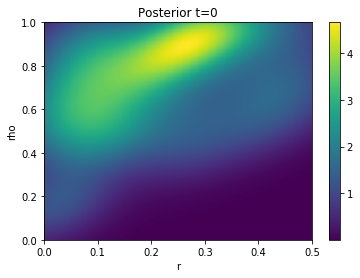

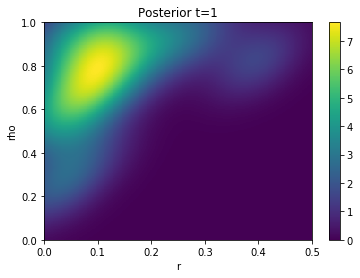

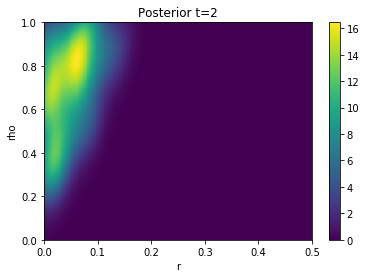

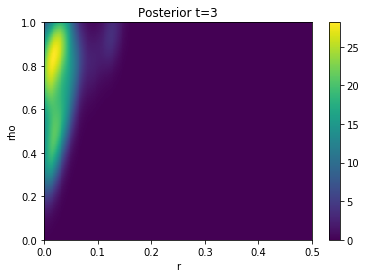

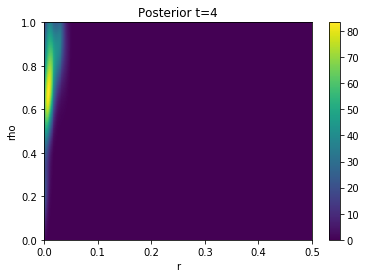

In [27]:
for t in range(h.max_t+1):
    ax = plot_kde_2d(*h.get_distribution(m=0, t=t),
                     "r", "rho",
                xmin=0, xmax=0.5, numx=300,
                ymin=0, ymax=1, numy=300)
    ax.set_title("Posterior t={}".format(t))

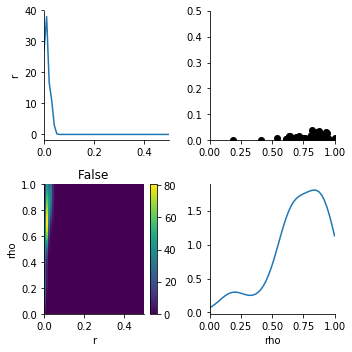

In [28]:
from pyabc.visualization import plot_kde_matrix

df, w = h.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits);

In [29]:
0.080/0.12

0.6666666666666667